# Experiment 2: Transfer learning for ConvNP

When training the ConvNP for data assimilation, we want to be able to first train the model on a broad dataset, covering a large portion of Australasia. We then want to refine the ConvNP for predictions on a narrower dataset, specifically for New Zealand. To make a plan for what context, auxiliary and target sets we use, we need to know how the default model structure changes to different input structures.

Things which need to be considered:
- Target resolution/model internal density
- Input scale
- Number of context sets
- Number of target sets
- Multi-output vs single-output?

Note: if the encoder changes structure but the decoder stays the same, then we might be able to train seperate encoders, but share the decoder structure?

In [1]:
# setup project root for imports (requirement for all notebooks in this repo)
import sys
from pathlib import Path

# Make project root importable
ROOT = Path().resolve().parents[1]
sys.path.append(str(ROOT))

In [3]:
# setup logging (useful for running with nohup)
from src.config.logging_config import setup_logging
import logging

setup_logging()  # configure logging
logger = logging.getLogger(__name__)
logger.info("Notebook execution started.")

2025-11-29 18:22:14 - INFO - __main__ - Notebook execution started.


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
from src.utils.variables.var_names import *
from src.utils.variables.coord_names import *
from src.data_processing.conversions.scalar_conversions import *
from src.config.env_loader import get_env_var
import src.learning.model_diagnostics as model_diagnostics
from src.learning.model_training import batch_data_by_num_stations, compute_val_loss

from src.data_processing.station_processor import ProcessStations
from src.data_processing.topography_processor import ProcessTopography
from src.data_processing.era5_processor import ProcessERA5

from src.data_processing.auxiliary.sun_position import get_sun_culmination

In [4]:
# DeepSensor imports
# note this pulls from a fork of DeepSensor.
import deepsensor.torch
from deepsensor.train.train import train_epoch, set_gpu_default_device
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP
from deepsensor.data.utils import construct_x1x2_ds

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.basemap import Basemap
import torch
from torch import optim
import os
import lab as B
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cf

In [5]:
# setup variables for experiment
years = [2010, 2011, 2012, 2013, 2014]

train_years = [2010, 2011, 2012, 2013]
validation_years = [2014]

# GPU settings
use_gpu = True
if use_gpu:
    cuda_device = int(get_env_var("CUDA_DEVICE"))
    set_gpu_default_device(backend="cuda", dev_id=cuda_device)

# visualisations of data
DEBUG_PLOTS = True

In [6]:
# dataset loader modules. These are from src.data_processing.
#    They use a file loader module in src.data_processing.file_loaders to load raw data files,
#    in the case of getting data in a different structure, changes will need to be made to the file loader modules.
station_processor = ProcessStations()
topography_processor = ProcessTopography()
era5_processor = ProcessERA5()

# topography and ERA5 datasets are loaded as simple xarray datasets
topography_ds = topography_processor.load_ds(standardise_var_names=True, standardise_coord_names=True)
era5_ds = era5_processor.load_ds(mode="surface", years=years, standardise_var_names=True, standardise_coord_names=True)

## Establish a baseline ConvNP

Establish a baseline ConvNP for temperature prediction, trained on a broad dataset with the following sets/channels:

Context 0:
- A random half-split of weather station readings

Context 1:
- Highly coarsened ERA5 data
- Cos(zenith) sun position encoding

Auxiliary:
- Topography & TPI for just New Zealand
- x0 and x1 positional encodings

Target:
- The remaining weather station readings

The model should be trained to interpolate the temperature values at the held-out sample of stations. For now, just the temperature value is being predicted. In the future it may make sense to predict the difference from the ERA5 temperature.

In [7]:
# build context set 1 (same pattern as experiment 1)

# clean up the ERA5 data:
# get variable filters a dataset to a single variable dataarray
era5_var = era5_processor.get_variable(era5_ds, TEMPERATURE) # set variable to process - e.g. "temperature"
era5_var = kelvin_to_celsius(era5_var)
era5_ds[TEMPERATURE] = era5_var

# add sun culmination context to the dataset
era5_ds[SUN_CULMINATION] = get_sun_culmination(era5_ds.coords)
era5_ds = era5_ds[[TEMPERATURE, SUN_CULMINATION]]

COARSEN_ERA_5_FACTOR = 10 # heavily coarsen ERA5 for initial model training
era5_ds_coarsen = era5_ds.coarsen(lat=COARSEN_ERA_5_FACTOR, lon=COARSEN_ERA_5_FACTOR, boundary='trim').mean()

In [ ]:
# build the auxiliary set (same pattern as experiment 1)
ds_aux = topography_processor.compute_tpi(topography_ds, window_sizes=[0.1])

AUXILIARY_COARSEN_FACTOR = 100
ds_aux_coarse  = ds_aux.coarsen(
    lat=AUXILIARY_COARSEN_FACTOR, 
    lon=AUXILIARY_COARSEN_FACTOR, 
    boundary='trim').mean()

# FYI training loop fails if you don't do this
ds_aux = ds_aux.fillna(0)
ds_aux_coarse = ds_aux_coarse.fillna(0)

In [ ]:
# build the station dataset (context & target set)

# load the stations with the variable of interest between the start and end years
stations_df = station_processor.load_df(vars=[TEMPERATURE], year_start=2010, year_end=2014)
stations_df.head()
stations_reset = stations_df.reset_index()
stations_reset.drop(columns=['station'], inplace=True)

# resample to six-hourly frequency to match ERA5 timestamps
stations_resample = stations_reset.groupby(['lat', 'lon']).resample("6h", on='time').mean()[[TEMPERATURE]]
stations_resample = stations_resample.reset_index().set_index(['time', 'lat', 'lon']).sort_index()

# drop station gisborne aero aws (too close to other station)
drop_lat, drop_lon = -38.66100, 177.98600

stations_resample = stations_resample[~((stations_resample.index.get_level_values('lat') == drop_lat) 
                                        & (stations_resample.index.get_level_values('lon') == drop_lon))]

logger.info("Data pre-processing completed.")

/home/crowelenn/niwa/convcnp-assim-nz/src/data_processing/station_processor.py:157: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  ds_comb = xr.concat([first, *station_iter], dim="station")
/tmp/ipykernel_137275/2551418850.py:10: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stations_resample = stations_reset.groupby(['lat', 'lon']).resample("6h", on='time').mean()[[TEMPERATURE]]


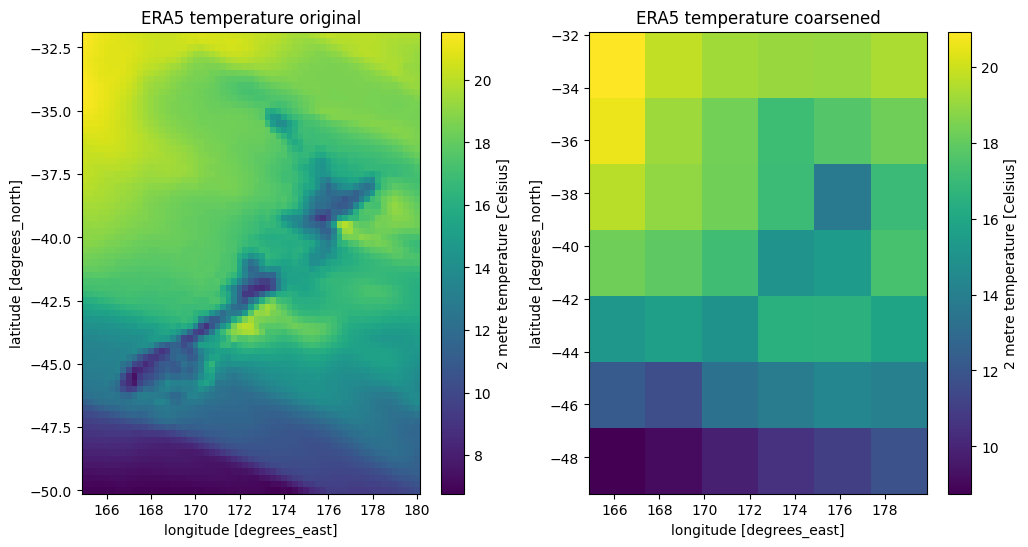

In [10]:
# visual check of correctness for ERA5
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
era5_ds.sel(time="2010-01-01T18:00")[TEMPERATURE].plot(ax=ax[0])
ax[0].set_title(f"ERA5 {TEMPERATURE} original") 
era5_ds_coarsen.sel(time="2010-01-01T18:00")[TEMPERATURE].plot(ax=ax[1])
ax[1].set_title(f"ERA5 {TEMPERATURE} coarsened")
plt.show()

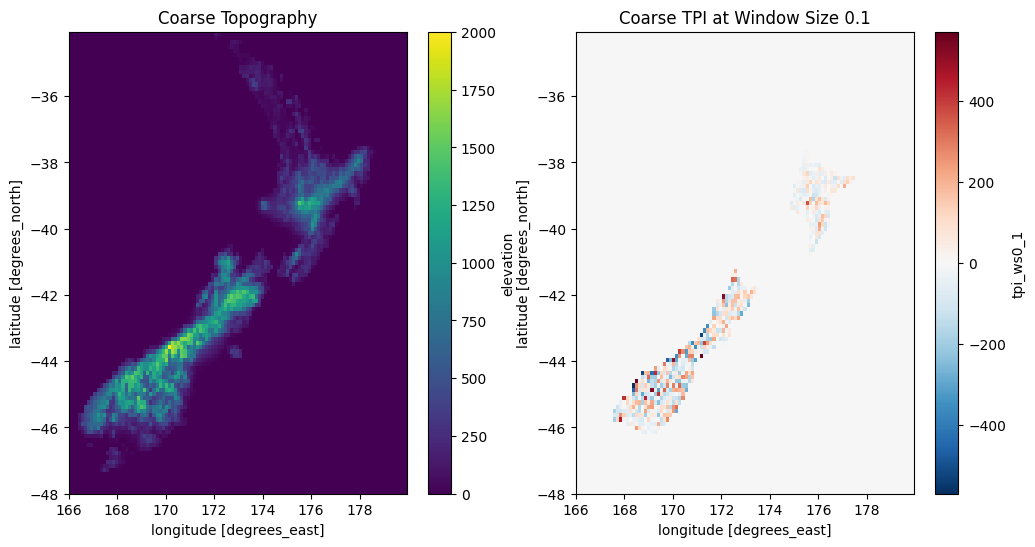

In [11]:
# visual check of correctness for topography
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ds_aux_coarse[ELEVATION].plot(ax=ax[0])
ax[0].set_title("Coarse Topography")

ds_aux_coarse[f"{TOPOGRAPHIC_POSITION_INDEX}_ws0_1"].plot(ax=ax[1])
ax[1].set_title("Coarse TPI at Window Size 0.1")

plt.show()

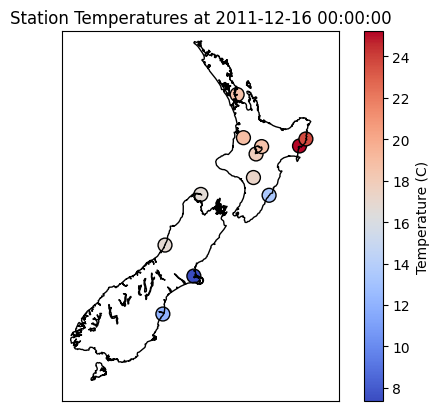

In [12]:
# visual check of correctness for stations
time_step = "2011-12-16 00:00:00"
m = Basemap(projection='merc', llcrnrlat=-48, urcrnrlat=-34, llcrnrlon=166, urcrnrlon=180, resolution='i')
m.drawcoastlines()
m.drawcountries()
x, y = m(stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lon'].values,
           stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lat'].values)
sc = m.scatter(x, y,
               c=stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['temperature'].values,
               cmap='coolwarm', marker='o', edgecolor='k', s=100)
plt.colorbar(sc, label='Temperature (C)')
plt.title(f'Station Temperatures at {time_step}')
plt.show()

Train the baseline model

In [ ]:
# data pre-processing
data_processor = DataProcessor(x1_name=LATITUDE, x1_map=(era5_ds[LATITUDE].min(), era5_ds[LATITUDE].max()), x2_name=LONGITUDE, x2_map=(era5_ds[LONGITUDE].min(), era5_ds[LONGITUDE].max()))
era5_processed, station_processed = data_processor([era5_ds_coarsen, stations_resample])
ds_aux_processed, ds_aux_coarse_processed = data_processor([ds_aux, ds_aux_coarse], method='min_max')

x1x2_ds = construct_x1x2_ds(ds_aux_coarse_processed)
ds_aux_coarse_processed['x1_arr'] = x1x2_ds['x1_arr']
ds_aux_coarse_processed['x2_arr'] = x1x2_ds['x2_arr']

task_loader = TaskLoader(
        context = [station_processed, era5_processed, ds_aux_coarse_processed], 
        target = station_processed, 
        aux_at_targets = ds_aux_processed, 
        links = [(0, 0)])

model = ConvNP(data_processor, task_loader, unet_channels=(64,)*5, likelihood="gnp")

print(model.config)

task_loader.load_dask()

train_dates = era5_ds.sel(time=slice("2010-01-01", "2011-12-31")).time.values
val_dates = era5_ds.sel(time=slice("2012-01-01", "2012-06-30")).time.values

train_tasks = []
for date in train_dates:
    task = task_loader(date, context_sampling=["split", "all", "all"], target_sampling=["split"], split_frac=0.5)
    train_tasks.append(task)


val_tasks = []
for date in val_dates:
    task = task_loader(date, context_sampling=["split", "all", "all"], target_sampling=["split"], split_frac=0.5)
    val_tasks.append(task)

task_batched = batch_data_by_num_stations(train_tasks, batch_size=16)

logger.info("Task loader setup completed. Beginning model training.")

/home/crowelenn/niwa/convcnp-assim-nz/venv/src/deepsensor/deepsensor/data/processor.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"x1_map={x1_map} and x2_map={x2_map} have different ranges ({float(np.diff(x1_map))} "
/home/crowelenn/niwa/convcnp-assim-nz/venv/src/deepsensor/deepsensor/data/processor.py:130: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"and {float(np.diff(x2_map))}, respectively). "
/home/crowelenn/niwa/convcnp-assim-nz/venv/src/deepsensor/deepsensor/data/processor.py:128: UserWarning: x1_map=(-50.0, -32.0) and x2_map=(165.0, 180.0) have different ranges (18.0 and 15.0, respectively). This can lead to stretching

dim_yc inferred from TaskLoader: (1, 2, 4)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 2
Setting aux_t_mlp_layers: (64, 64, 64)
internal_density inferred from TaskLoader: 140
encoder_scales inferred from TaskLoader: [0.0035714285714285713, 0.0694444477558136, 0.0035555537324398756]
decoder_scale inferred from TaskLoader: 0.007142857142857143
{'dim_x': 2, 'dim_yc': (1, 2, 4), 'dim_yt': 1, 'dim_aux_t': 2, 'dim_lv': 0, 'conv_arch': 'unet', 'unet_channels': (64, 64, 64, 64, 64), 'unet_resize_convs': True, 'unet_resize_conv_interp_method': 'bilinear', 'aux_t_mlp_layers': (64, 64, 64), 'likelihood': 'lowrank', 'unet_kernels': 5, 'internal_density': 140, 'encoder_scales': [0.0035714285714285713, 0.0694444477558136, 0.0035555537324398756], 'encoder_scales_learnable': False, 'decoder_scale': 0.007142857142857143, 'decoder_scale_learnable': False, 'num_basis_functions': 64, 'epsilon': 0.01}


100%|██████████| 728/728 [00:12<00:00, 58.62it/s]


In [ ]:
# training loop. Train baseline model for 50 epochs.

n_epochs = 50
train_losses = []
val_losses = []
lr=5e-5

output_model = False

val_loss_best = np.inf

opt = optim.Adam(model.model.parameters(), lr=lr)

for epoch in range(n_epochs):
    batch_losses = [train_epoch(model, task_batched[f'{num_stations}'], 
                                            batch_size=len(task_batched[f'{num_stations}']), 
                                            lr=lr, opt=opt) for num_stations in task_batched.keys()]
    
    train_loss = np.mean(batch_losses)
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss = compute_val_loss(model, val_tasks)
    val_losses.append(val_loss)

    if val_loss < val_loss_best:
        val_loss_best = val_loss
        if output_model:
            folder = os.path.join(get_env_var("OUTPUT_HOME"), "models", "downscaling", "temperature", "convcnp")
            if not os.path.exists(folder): os.makedirs(folder)
            torch.save(model.model.state_dict(), folder + f"model.pt")

    torch.cuda.empty_cache()

    if (epoch + 1) % 5 == 0:
        logger.info(f"Epoch {epoch+1} train_loss: {train_loss:.2f}, val_loss: {val_loss:.2f}")
    

  0%|          | 0/2 [00:00<?, ?it/s]/home/crowelenn/niwa/convcnp-assim-nz/venv/lib/python3.12/site-packages/lab/types.py:204: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numerictypes.
  for name in np.core.numerictypes.__all__ + ["bool"]:
 50%|█████     | 1/2 [00:54<00:54, 54.94s/it]

Epoch 0 train_loss: 1.76, val_loss: 1.77


100%|██████████| 2/2 [01:49<00:00, 54.65s/it]

Epoch 1 train_loss: 1.66, val_loss: 1.84


In [ ]:
# save the model to OUTPUT_HOME/models/exp2_transfer_learning/baseline.pt
folder = os.path.join(get_env_var("OUTPUT_HOME"), "models", "exp2_transfer_learning", "baseline")

model.save(str(folder))

logger.info(f"Model training completed. Model saved to {folder}")